In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import f1_score


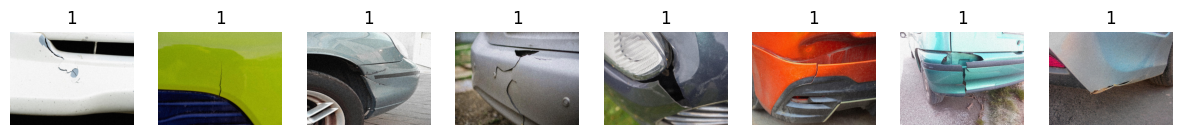

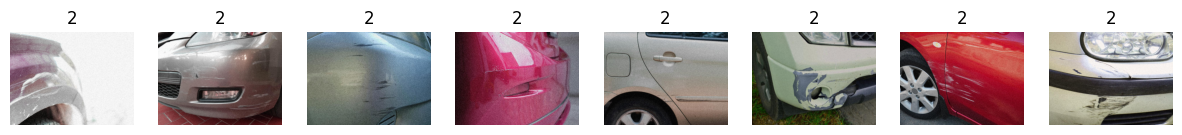

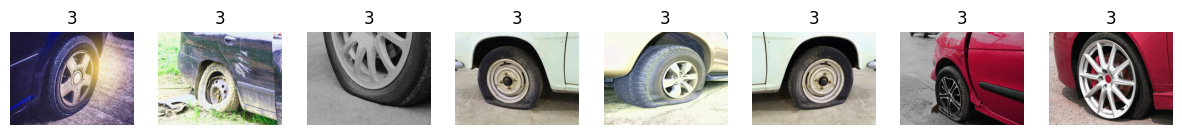

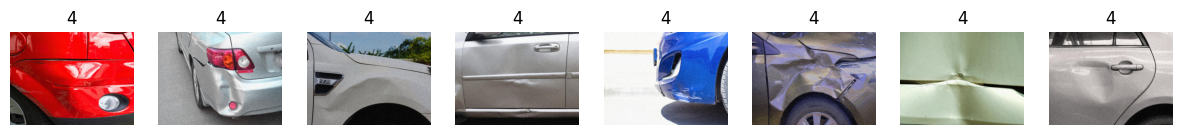

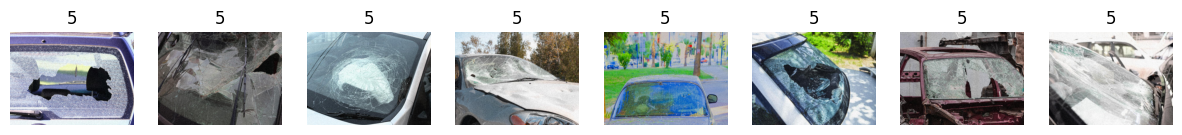

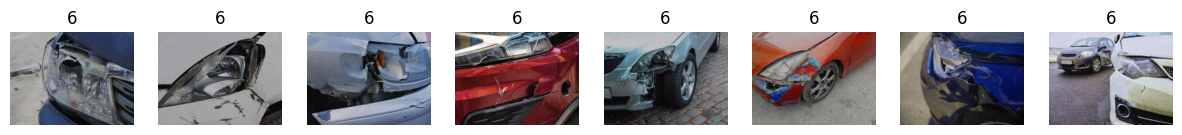

In [2]:
# let's see what out data looks like and corresponding labels
labels_df= pd.read_csv('train/train.csv')
for label_value in range(1,7):
  images= labels_df[labels_df.label==label_value]['filename'][:10].values
  fig, ax = plt.subplots(1, 8, figsize=(15, 8))
  for j in range(8):
          img = mpimg.imread('train/images/' + images[j])
          ax[j].imshow(img)
          ax[j].set_title(label_value)
          ax[j].axis('off')



### visual inspection reveals that 5 represents front glass damage, 3 tire failure, 4 dent in the car and so on

In [3]:
# let's get mean and std of our image data set to normalise
from data_preprocessing import get_mean_std, get_data_loaders
#mean, std = get_mean_std('train/images/')
#Mean: [0.47770813 0.45964807 0.46059614]
#Std: [0.27100051 0.26614914 0.26896046]

In [4]:
labels_df.head()

,image_id,filename,label
0,1,1.jpg,2
1,2,2.jpg,4
2,3,3.jpg,2
3,4,4.jpg,3
4,5,5.jpg,5


In [5]:
train_loader, test_loader = get_data_loaders(batch_size=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

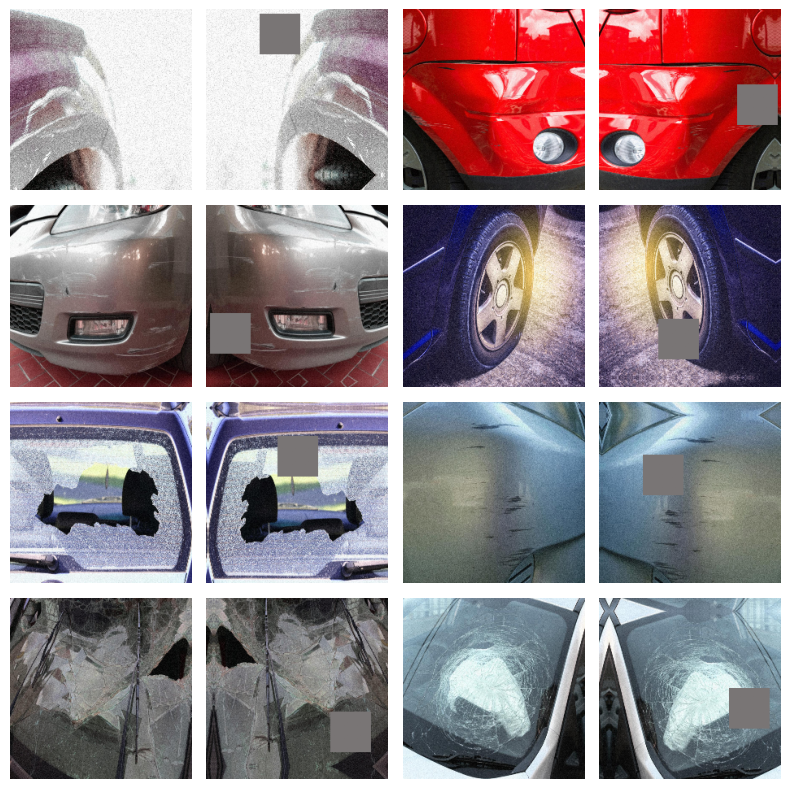

In [6]:
# visualise transformed images
from data_preprocessing import visualise_transformation
visualise_transformation()

In [7]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)

num_classes = 6  # Set this to the number of your classes


# Replace the last fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

model.to(device)

for param in model.parameters():
    param.requires_grad = False

# Enable training for the final layer
for param in model.fc.parameters():
    param.requires_grad = True

/Users/hemantbhambhu/Documents/Ripik_ai_competition/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hemantbhambhu/Documents/Ripik_ai_competition/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Only train final layer

num_epochs = 2  # Number of training epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        # Forward pass
        images,labels= images.to(device),labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Calculate accuracy
        train_correct += (outputs.argmax(1) == labels).sum().item()
        train_total += labels.size(0)

        # Backward and optimize

        loss.backward()
        optimizer.step()

        train_accuracy = 100 * train_correct / train_total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.2f}%')



Epoch [1/2], Loss: 1.7904, Training Accuracy: 14.06%
Epoch [1/2], Loss: 1.5859, Training Accuracy: 25.00%
Epoch [1/2], Loss: 1.8709, Training Accuracy: 26.04%
Epoch [1/2], Loss: 1.7026, Training Accuracy: 26.95%


KeyboardInterrupt: 

In [ ]:

#torch.save(model, 'ripik_model.pth')
# model = torch.load('ripik_model.pth', map_location=torch.device('cpu'))
# model.eval()  

In [ ]:
model.eval()  # Set the model to evaluation mode

predictions = []
for images, img_names in test_loader:
    images= images.to(device)
    with torch.no_grad():
        outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    predictions.extend(zip(img_names, predicted.cpu().numpy()+1))  # Store image names and predictions

In [ ]:
# get the f1 score 



y_true = [x[0] for x in predictions]
y_pred = [x[1] for x in predictions]

f1_score(y_true, y_pred, average='macro')